# Assignment 06

## Social Network Analysis

### Luciano Carvalho

## CSCI E-108

## Introduction

In this assignment you will gain some experience with several algorithms used for the analysis of social networks. There are two running examples. The first dataset is a simple purely synthetic network. The second dataset is a widely used example of a small real-world social network.  

Anthropologist Wayne Zachary observed the social interactions between members of a small real-world [karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) over a two year period. Toward the end of the study period a conflict arose which caused the club to split into 2. Some club members stayed connect to a group centered on a founder, Mr Hi. Other members started a new club. Zachary published his results in [1977](https://www.jstor.org/stable/3629752).   

> **Required packages:** Before running the code in this notebook you will need to install the [NetworkX package](https://networkx.org/). The NetworkX has a dependency on [PyGraphViz](https://pygraphviz.github.io/). If you have not installed these packages un-comment the code below and install both. Especailly, if you are using the Windows OS, or have instalaiton problems on any OS, read these [PyGraphViz installation instructions](https://pygraphviz.github.io/documentation/stable/install.html) carefully. Finally, you will use the Louvain modularity algorithm from the Python [Community](https://python-louvain.readthedocs.io/en/latest/index.html) package.     

In [6]:
## Install NetworkX if it is not already present.
!pip install networkx

## You may need to install PyGraphViz. This instillation will fail on Windows.
!apt-get install graphviz graphviz-dev
!pip install pygraphviz

## You may need to install the community package if it is not already present.
!pip install community

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Execute the code in the cell below to import the packages you will need for this assignment.

In [7]:
import numpy as np
from scipy.sparse.linalg import eigs
import networkx as nx
import itertools
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import modularity, greedy_modularity_communities
import community as community_louvain
import matplotlib.pyplot as plt

%matplotlib inline

## Data Samples

In this assignment you will work with two datasets. The first is a simple synthetic network. The second is the karate club dataset.

To create and plot the first dataset execute the code in the cell below. Notice the two clear communities.  

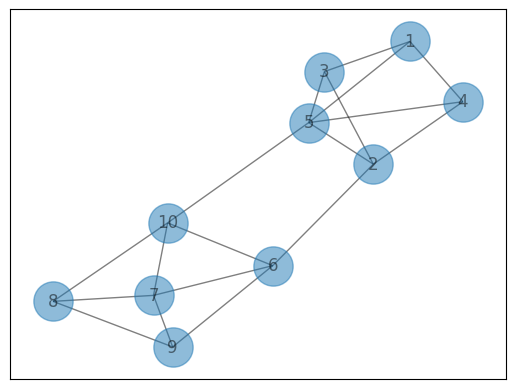

In [8]:
edge_list = [(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(2,6),(3,5),(4,5),(5,10),(6,7),(6,9),(6,10),(7,8),(7,9),(7,10),(8,9),(8,10)]
simple_graph = nx.Graph()
simple_graph.add_nodes_from([1,2,3,4,5,6,7,8,9,10])
simple_graph.add_edges_from(edge_list)

nx.draw_networkx(simple_graph, with_labels=True, alpha=0.5, node_size=800)

To import and plot the karate club dataset execute the code in the cell below. The structure of this social network is fairly complex. However, you can see that some nodes clearly have some amount of centrality.

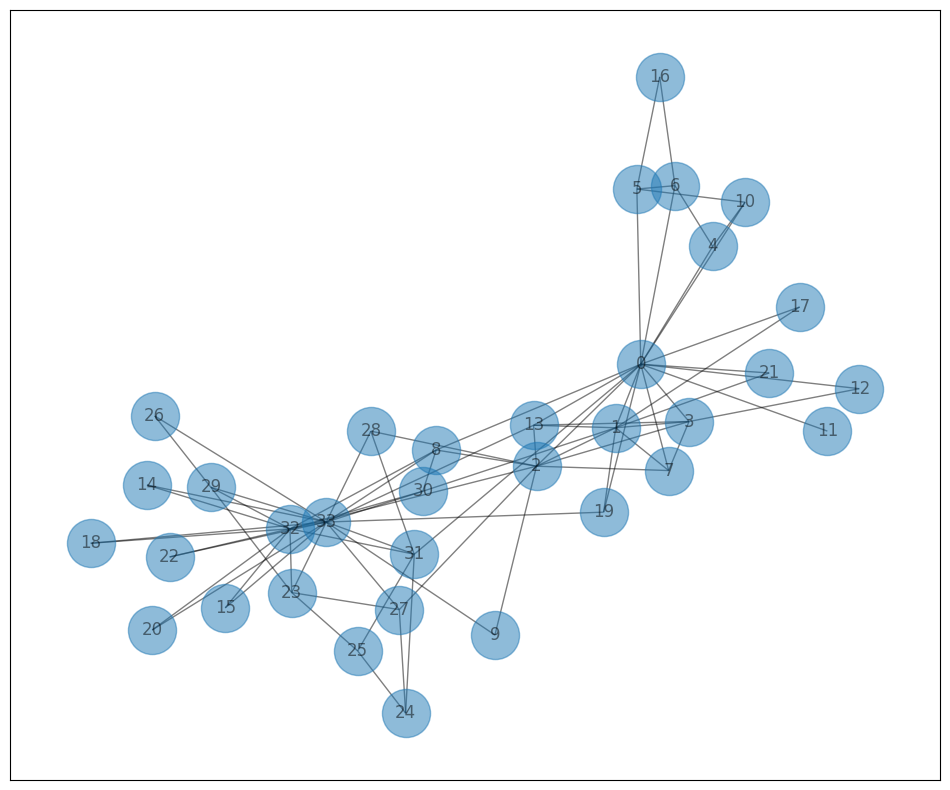

In [9]:
K_club = nx.karate_club_graph()

fig,ax = plt.subplots(figsize=(12,10))
nx.draw_networkx(K_club, with_labels=True, alpha=0.5, node_size=1200, ax=ax)

## Measures of Centrality

You will now compute and assess measures of centrality for both graphs. The goal is to find the nodes with the greatest influence measured by centrality.   

### Closeness Centrality

Closeness centrality is a simple centrality metric. Nodes with a small average inverse distance to the other nodes in the network are considered to have higher centrality.  

Execute the code in the cell below to compute and display the closeness centrality of the simple graph. This code uses the [networkx.algorithms.centrality.closeness_centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html?highlight=closeness%20centrality) function.   

In [10]:
simple_closeness_centrality = nx.closeness_centrality(simple_graph)
simple_closeness_centrality

{1: 0.45,
 2: 0.6,
 3: 0.5,
 4: 0.5,
 5: 0.6428571428571429,
 6: 0.6,
 7: 0.5294117647058824,
 8: 0.47368421052631576,
 9: 0.45,
 10: 0.6428571428571429}

A graphical display of centrality metrics of a graph is often very useful in terms of interpreting the results. Execute the code in the cell below to display the closeness centrality of the simple graph.

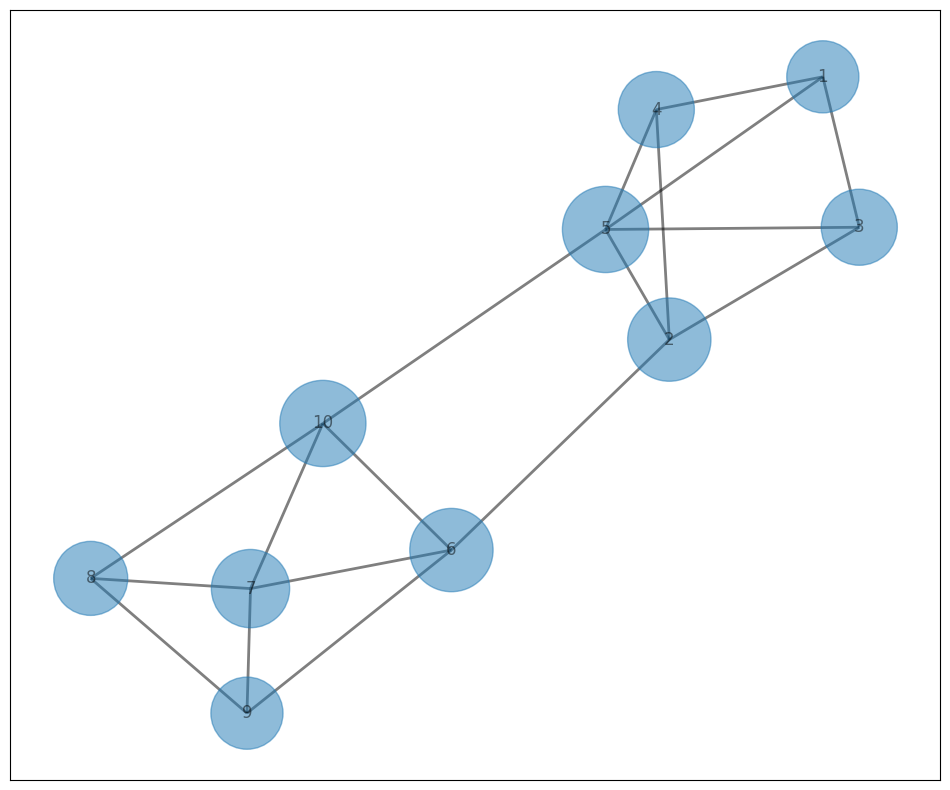

In [11]:
def plot_centrality(G, node_centrality=None, edge_centrality=None, size=1.0, width=2.0):
    fig,ax = plt.subplots(figsize=(12,10))
    ## Set the node sizes to display if provided
    if node_centrality==None:
        node_size=size
    else:
        node_size = [size*node_centrality[key] for key in node_centrality.keys()]
    ## Set the edge width to display if provided
    if edge_centrality==None:
        edge_width=width
    else:
        edge_width = [width*edge_centrality[u,v] for u,v in edge_centrality.keys()]
    ## Display the graph
    nx.draw_networkx(G, with_labels=True, alpha=0.5, node_size=node_size, width=edge_width, ax=ax)

plot_centrality(simple_graph, simple_closeness_centrality, size=6000, width=2)

There range of the closeness centrality values is limited. None the less, the results look reasonable since the nodes with the highest closeness centrality are concentrated around the middle of the graph, and more peripheral nodes have low closeness centrality.

> **Exercise 06-1:** You will now compute and display the closeness centrality of the karate club graph by the following steps:   
> 1. Compute the closeness centrality of the graph using the [networkx.algorithms.centrality.closeness_centrality](https://networkx.org/documentation/stable/search.html?q=closeness) function.  
> 2. Plot the closeness centrality of the graph using the `plot_centrality` function.  
> 3. Print the centrality of the graph nodes.

{0: 0.5689655172413793, 1: 0.4852941176470588, 2: 0.559322033898305, 3: 0.4647887323943662, 4: 0.3793103448275862, 5: 0.38372093023255816, 6: 0.38372093023255816, 7: 0.44, 8: 0.515625, 9: 0.4342105263157895, 10: 0.3793103448275862, 11: 0.36666666666666664, 12: 0.3707865168539326, 13: 0.515625, 14: 0.3707865168539326, 15: 0.3707865168539326, 16: 0.28448275862068967, 17: 0.375, 18: 0.3707865168539326, 19: 0.5, 20: 0.3707865168539326, 21: 0.375, 22: 0.3707865168539326, 23: 0.39285714285714285, 24: 0.375, 25: 0.375, 26: 0.3626373626373626, 27: 0.4583333333333333, 28: 0.4520547945205479, 29: 0.38372093023255816, 30: 0.4583333333333333, 31: 0.5409836065573771, 32: 0.515625, 33: 0.55}


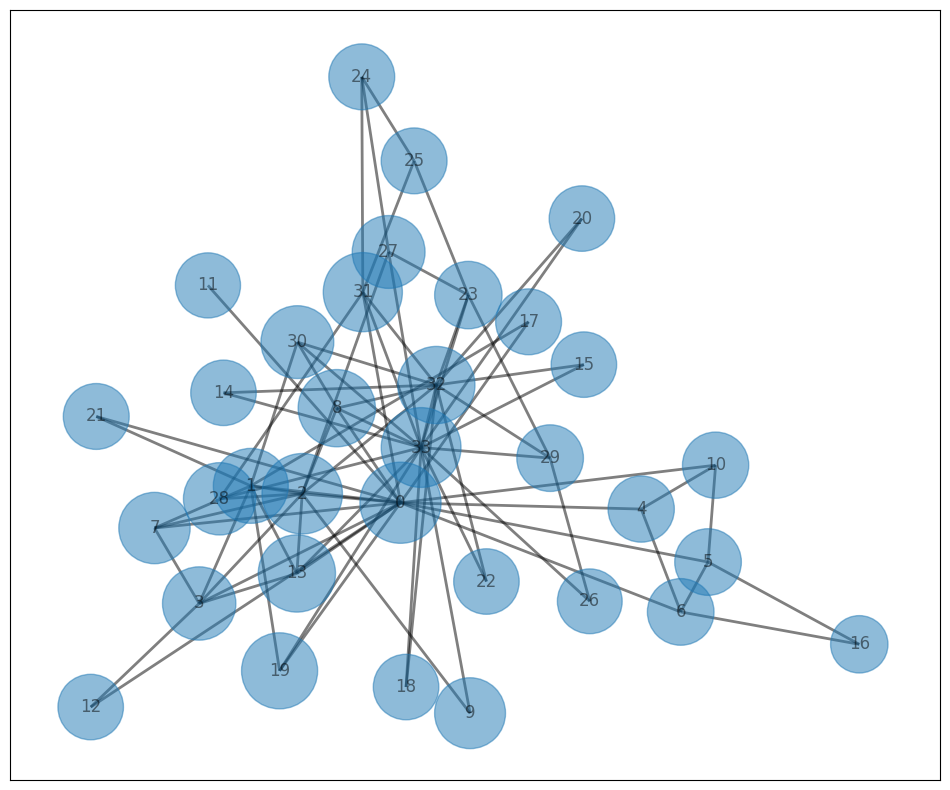

In [12]:
# 1: Compute the closeness centrality
K_club_closeness_centrality = nx.closeness_centrality(K_club)

# 2: Plot the closeness centrality
plot_centrality(K_club, K_club_closeness_centrality, size=6000, width=2)

# 3: Print the centrality values
print(K_club_closeness_centrality)

> Examine both the numerical values of closeness centrality and the plot. What statement can you make about how well the closeness centrality represents the connectedness of the network?     
> **End of exercise.**

> **Answer:** The closeness centrality values and plot for the karate club graph show that nodes like 0 and 2, with high centrality scores, are well-connected and can quickly interact with others, making them important for spreading information. In contrast, nodes with lower scores, like node 16, are on the network's periphery and have fewer connections, meaning they're less influential. Overall, closeness centrality seems to capture how central or connected each node is, matching the intuition that nodes closer to the middle of the network are more vital for communication

### K-Cores

K-cores are a metric of connection density at the densest part of a community, the core. A node, $n_i$, is in the k-core if at least $k$ edges can be removed without breaking the component containing the node into parts. At the minimum, a k-core node must have at least $degree(n_i) = k_i > k$.

The [networkx.k_componentse](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.kcomponents.k_components.html) function iterates over values of k. The function starts from $k=1$ and terminates at the value of $k$ where all nodes are in disconnected components. To see how the core components evolved for the simple example graph execute the code in the cell below.   

In [13]:
nx.k_components(simple_graph)

{3: [{1, 2, 3, 4, 5}, {6, 7, 8, 9, 10}],
 2: [{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}],
 1: [{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}]}

The key of the displayed dictionary is the value of k. The values are the components for that value of k. At $k=3$ there are 2 disconnected components. For $k > 3$ the components become disconnected.  

To visualize the cores at the different values of k execute the code in the cell below.  

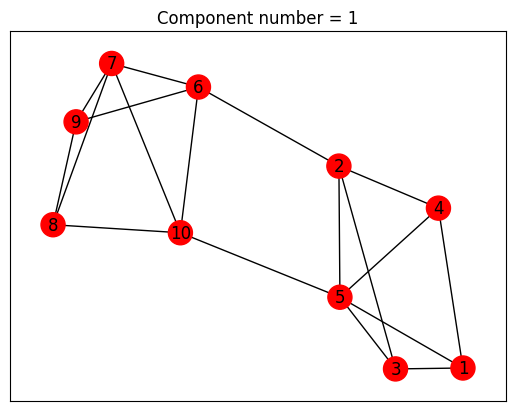

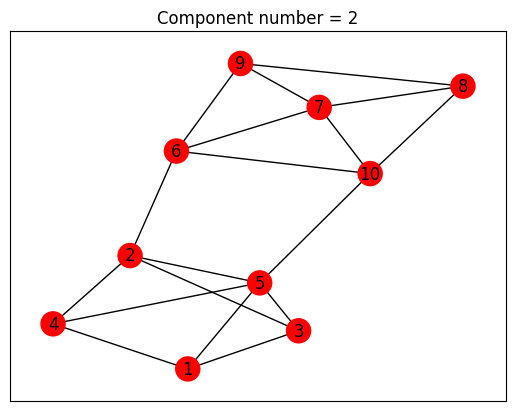

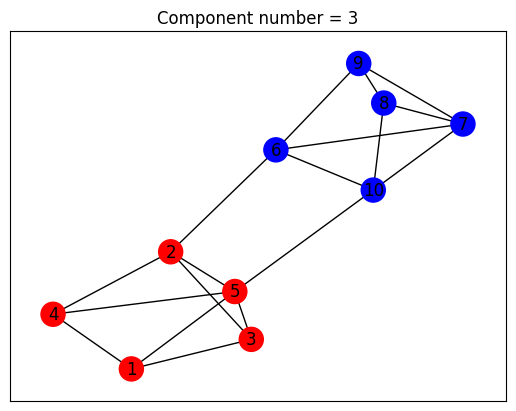

In [14]:
def plot_k_components(G, K_comps):
    for c in range(len(K_comps)): #[4,3,2,1]:
        node_colors = ['blue']*len(G.nodes)
        for node in K_comps[c+1][0]:
            node_colors[node-1] = 'red'
        nx.draw_networkx(G, node_color=node_colors, with_labels=True)
        plt.title('Component number = ' + str(c+1))
        plt.show()

K_comps = nx.k_components(simple_graph)
plot_k_components(simple_graph, K_comps)

Notice that for $k=3$ the simple graph is divided into two components. Given the structure of the communities, the selection of k-core nodes is a bit arbitrary. At termination, the algorithm must label nodes as core or not, and in this case, there is no particularly good division of the nodes.      

> **Exercise 06-2:** To visualize the k-cores of the karate club graph create and execute the code in the cell below to display these cores for different values of k. Hint: It will help your interpretation to print and examine the degree of the nodes in this graph, which is the [degree](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html?highlight=degree#networkx.Graph.degree) attribute of the graph object.

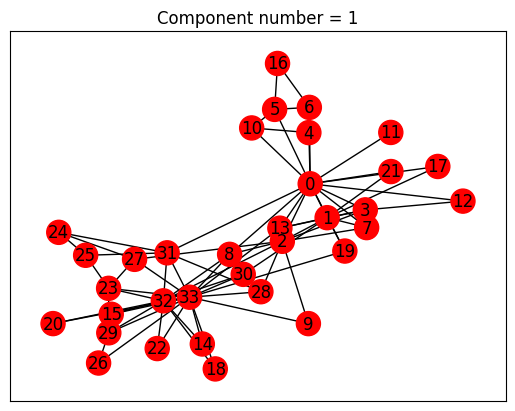

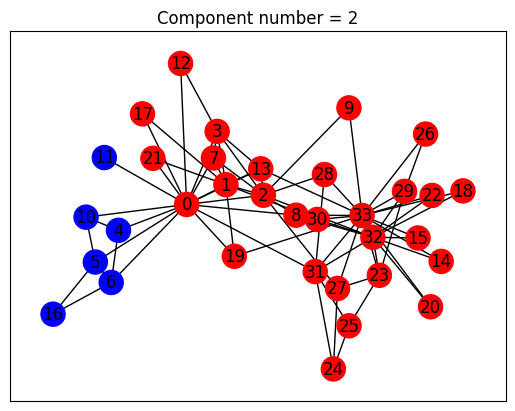

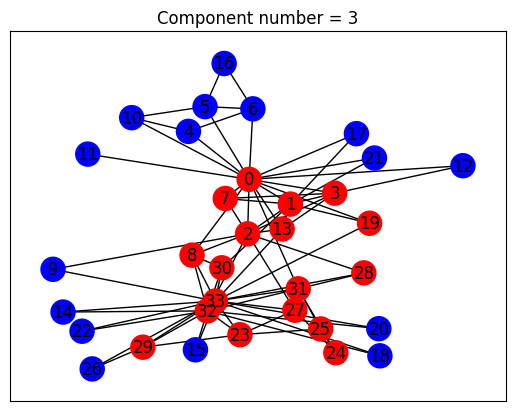

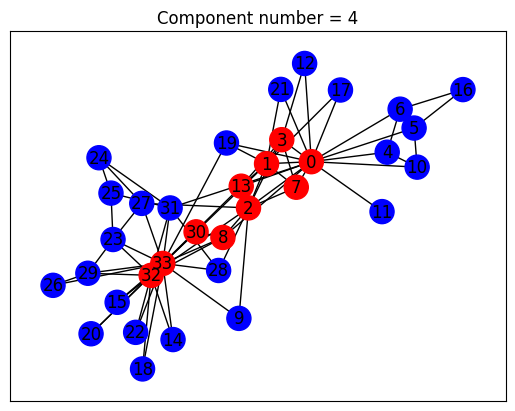

In [15]:
def plot_k_components_0_index(G, K_comps):
    for c in range(len(K_comps)): #[4,3,2,1]:
        node_colors = ['blue']*len(G.nodes)
        for node in K_comps[c+1][0]:
            node_colors[node] = 'red'
        nx.draw_networkx(G, node_color=node_colors, with_labels=True)
        plt.title('Component number = ' + str(c+1))
        plt.show()

# Compute k-components of the karate club graph
K_comps_karate = nx.k_components(K_club)

# Plot the k-cores for the karate club graph
plot_k_components_0_index(K_club, K_comps_karate)


> Examine these plots and provide short answers to the following questions:      
> 1. How do the members of the core nodes change with increasing k as related to centrality?      
> 2. How does membership in the k-core align with connectivity of the graph?        
> **End of exercise.**

> **Answers:**

> 1. As k increases, the number of core nodes decreases, and the remaining nodes tend to be those with higher centrality. This is because nodes with higher degree and more connections are more likely to stay connected as edges are removed. For example, nodes like 0 and 33 persist as core members at higher k-values, indicating their central and influential position in the network

> 2. Membership in the k-core aligns with the connectivity of the graph, as nodes in the core are those with a high number of connections, ensuring strong internal cohesion. As the value of k increases, the core becomes smaller and more exclusive, with only the most connected and central nodes remaining. This reflects that these nodes play a crucial role in maintaining the overall connectivity and structure of the network. Nodes that drop out of the core at lower k-values are typically those on the periphery with fewer connections, indicating weaker integration within the network's main structure


### Triangle Centrality and Clustering  

The density of triangles, or triad relationships, in a social network is a measure of the centrality of the nodes. Triangle density is computed using the [networkx.algorithms.cluster.triangles](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.triangles.html?highlight=triangle#networkx.algorithms.cluster.triangles) function. To see the triangle density of the simple graph example execute the code in the cell below.        

{1: 2, 2: 2, 3: 2, 4: 2, 5: 4, 6: 2, 7: 4, 8: 2, 9: 2, 10: 2}

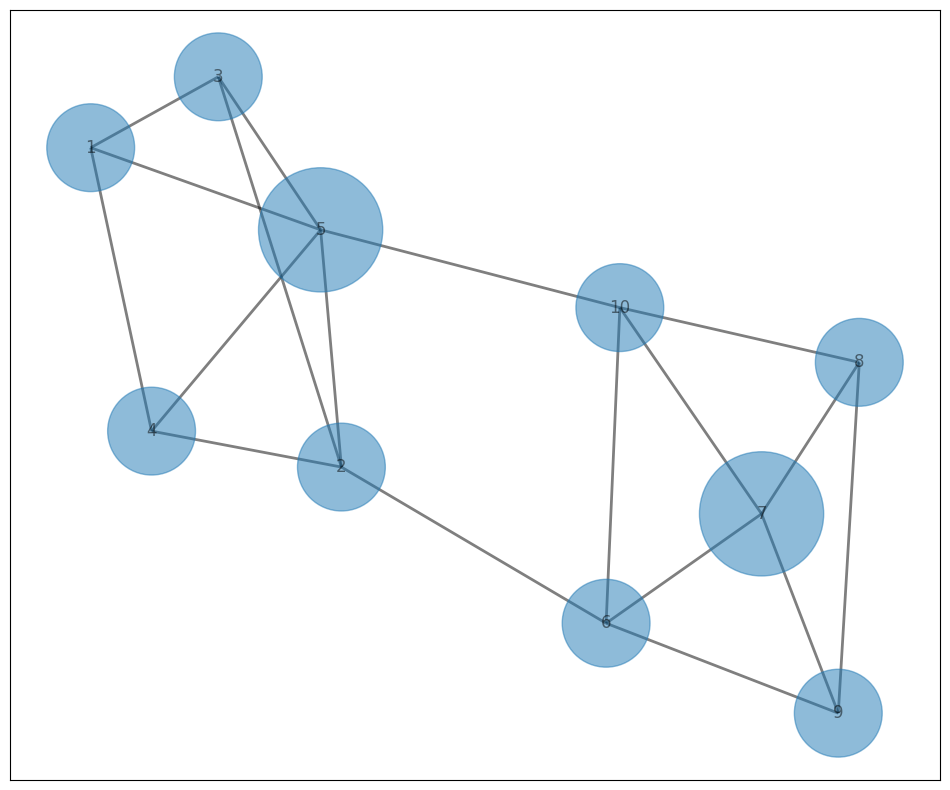

In [16]:
## Compute triangle density
triangles = nx.triangles(simple_graph)
plot_centrality(simple_graph, triangles, size=2000, width=2)
triangles

In the above plot you can see that two nodes have higher triangle density that the others. These nodes are vertices of 4 triangles, indicating centrality of these nodes.

Triangle centrality is a biased measure since nodes with higher degree are more likely to be vertices of a triad in a random graph. The clustering coefficient adjusts the triangle density of the nodes by the degree, which is done by the [networkx.algorithms.cluster.clustering](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html?highlight=clustering#networkx.algorithms.cluster.clustering) function. Execute the code to display the correlation coefficients for the simple graph.

{1: 0.6666666666666666,
 2: 0.3333333333333333,
 3: 0.6666666666666666,
 4: 0.6666666666666666,
 5: 0.4,
 6: 0.3333333333333333,
 7: 0.6666666666666666,
 8: 0.6666666666666666,
 9: 0.6666666666666666,
 10: 0.3333333333333333}

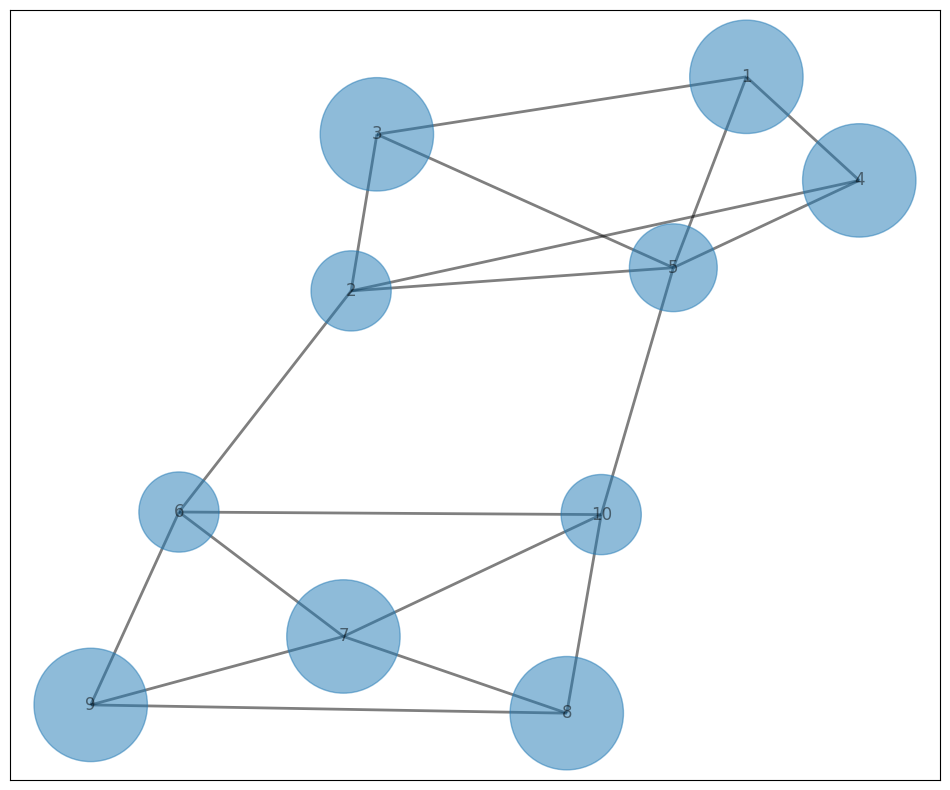

In [17]:
clustering = nx.clustering(simple_graph)
plot_centrality(simple_graph, clustering, size=10000, width=2)
clustering

There are several nodes with high clustering coefficients. Because of the small graph with significant symmetry several nodes have high clustering coefficients.    

> **Exercise 06-3:** Compute and display the triangle density for the karate club graph. Display the dictionary of triangle density and the plot.

{0: 18, 1: 12, 2: 11, 3: 10, 4: 2, 5: 3, 6: 3, 7: 6, 8: 5, 9: 0, 10: 2, 11: 0, 12: 1, 13: 6, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 4, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 4, 30: 3, 31: 3, 32: 13, 33: 15}


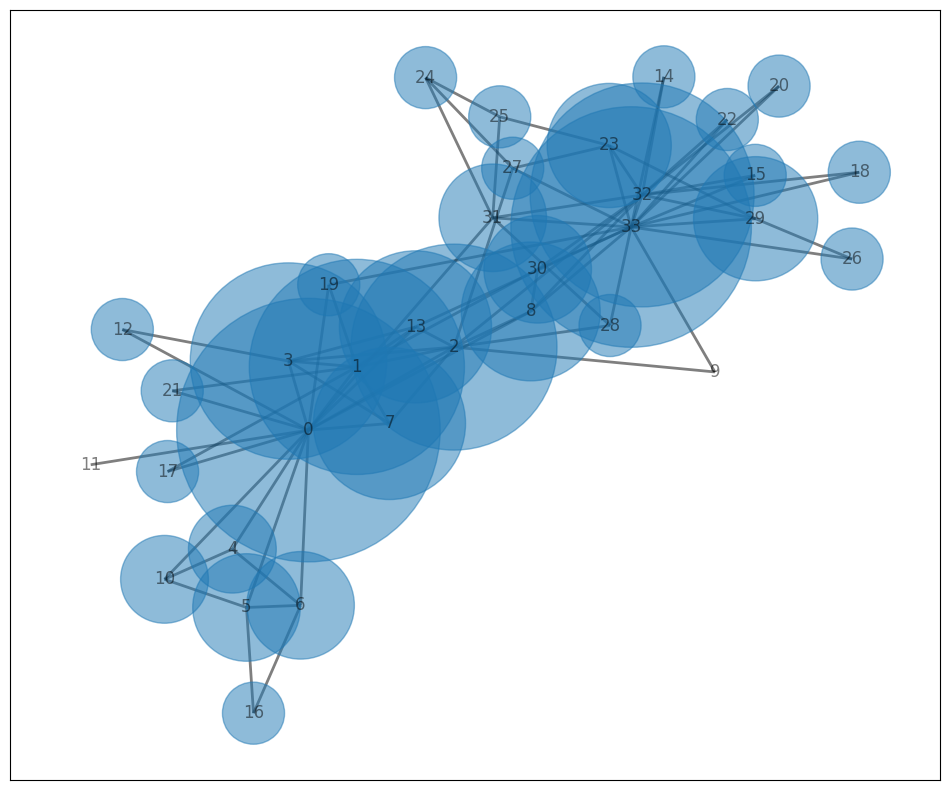

In [18]:
# Compute triangle density for the karate club graph
triangles_karate = nx.triangles(K_club)

# Plot the triangle density
plot_centrality(K_club, triangles_karate, size=2000, width=2)

# Display the dictionary of triangle density
print(triangles_karate)


> Examine the triangle density of this graph. How do the nodes with high triangle density compare to the $k=$ core components found in Exercise 06-2?       
> **End of exercise.**     

> **Answer:** In examining the triangle density of the karate club graph, we notice that nodes such as 0, 1, 2, 32, and 33 have the highest triangle densities, with node 0 having the highest value of 18. These nodes are prominently involved in many triadic relationships, indicating strong interconnectedness and central positions within the network. Comparing this with the k-core components found in Exercise 06-2, we see that the nodes with high triangle density overlap significantly with the core nodes at higher k-values. Specifically, nodes like 0, 1, 2, and 33 were consistently present in the core components as k increased, indicating they are key players in maintaining the network's structure. This alignment suggests that high triangle density is a good indicator of core membership, as these nodes not only participate in numerous triangles but also maintain the cohesion of the network's densest parts.

> **Exercise 06-4:** In the cell below create and execute the code to display the clustering coefficients of the karate club graph as a dictionary and a plot.   

{0: 0.15, 1: 0.3333333333333333, 2: 0.24444444444444444, 3: 0.6666666666666666, 4: 0.6666666666666666, 5: 0.5, 6: 0.5, 7: 1.0, 8: 0.5, 9: 0, 10: 0.6666666666666666, 11: 0, 12: 1.0, 13: 0.6, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 0.3333333333333333, 20: 1.0, 21: 1.0, 22: 1.0, 23: 0.4, 24: 0.3333333333333333, 25: 0.3333333333333333, 26: 1.0, 27: 0.16666666666666666, 28: 0.3333333333333333, 29: 0.6666666666666666, 30: 0.5, 31: 0.2, 32: 0.19696969696969696, 33: 0.11029411764705882}


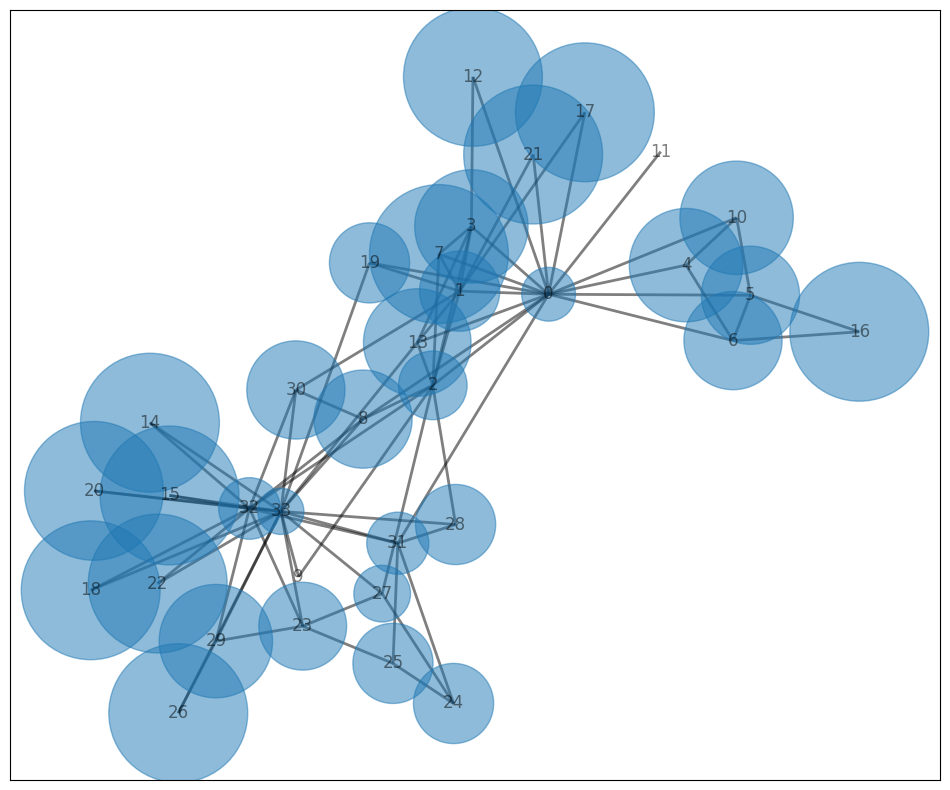

In [19]:
# Compute clustering coefficients for the karate club graph
clustering_karate = nx.clustering(K_club)

# Plot the clustering coefficients
plot_centrality(K_club, clustering_karate, size=10000, width=2)

# Display the dictionary of clustering coefficients
print(clustering_karate)


> Examine the results noticing how the clustering coefficient is down-weighted by the degree of the node. What pattern can you observe for the nodes with the highest and lowest clustering coefficients?    
> **End of exercise**

> **Answers:** In examining the clustering coefficients of the karate club graph, we observe that nodes with the highest clustering coefficients (values close to 1) generally have lower degrees, indicating they are part of tightly-knit subgroups or cliques. For example, nodes 7, 12, 14, 15, 16, 17, 18, 20, 21, and 26 all have a clustering coefficient of 1.0, suggesting that all their neighbors are interconnected, forming perfect cliques. On the other hand, nodes with lower clustering coefficients (values closer to 0) tend to have higher degrees or are more central in the network. For instance, node 0, which has a central position and the highest number of connections, has a clustering coefficient of only 0.15. Similarly, node 33, another central node, has a low clustering coefficient of 0.11. This pattern suggests that while these nodes are well-connected, their neighbors are not as interconnected, resulting in lower local clustering. Overall, the clustering coefficient tends to decrease with an increase in the node's degree, as high-degree nodes are likely to connect different subgroups within the network, making their local neighborhoods less densely connected.

## Betweenness

Betweenness is a measure of the number of shortest paths through a node or edge. Nodes and edges with high betweenness tend to be at the edges of communities within a graph. The node and edge betweenness often follow similar patterns, these different metrics can sometimes highlight different aspects of community structure.   

We use betweenness in two ways here. First to highlight community structure in the graph. The nodes and edges connecting communities tend to have the highest betweenness since there are relatively fewer paths between densely connected communities. Next, we will use the concept of betweenness to remove edges from graphs and partition them by communities.     

### Betweenness Centrality  

We can use the concept of either edge or node betweenness as a measure of centrality. Nodes and edges with high betweenness can define the edges of communities. The code in the cells below computes the edge betweenness with the [networkx.algorithms.centrality.edge_betweenness_centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html?highlight=betweenness#networkx.algorithms.centrality.edge_betweenness_centrality) function and the node betweenness with the [networkx.algorithms.centrality.betweenness_centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html?highlight=betweenness#networkx.algorithms.centrality.betweenness_centrality). Execute this code and examine the results.

In [20]:
edge_betweenness=nx.edge_betweenness_centrality(simple_graph)
edge_betweenness

{(1, 3): 0.0462962962962963,
 (1, 4): 0.0462962962962963,
 (1, 5): 0.1222222222222222,
 (2, 3): 0.10185185185185185,
 (2, 4): 0.10185185185185185,
 (2, 5): 0.07222222222222223,
 (2, 6): 0.25,
 (3, 5): 0.0851851851851852,
 (4, 5): 0.0851851851851852,
 (5, 10): 0.3055555555555556,
 (6, 7): 0.07962962962962962,
 (6, 9): 0.13518518518518519,
 (6, 10): 0.07962962962962962,
 (7, 8): 0.03518518518518519,
 (7, 9): 0.03888888888888889,
 (7, 10): 0.10555555555555558,
 (8, 9): 0.05185185185185186,
 (8, 10): 0.14629629629629629}

In [21]:
node_betweenness = nx.betweenness_centrality(simple_graph)
node_betweenness

{1: 0.009259259259259259,
 2: 0.20370370370370372,
 3: 0.020833333333333332,
 4: 0.020833333333333332,
 5: 0.29398148148148145,
 6: 0.21527777777777776,
 7: 0.03703703703703704,
 8: 0.02083333333333333,
 9: 0.0162037037037037,
 10: 0.27314814814814814}

Next, execute the code in the cell below to display a plot of the simple graph with node size showing betweenness centrality and edge width showing edge centrality.

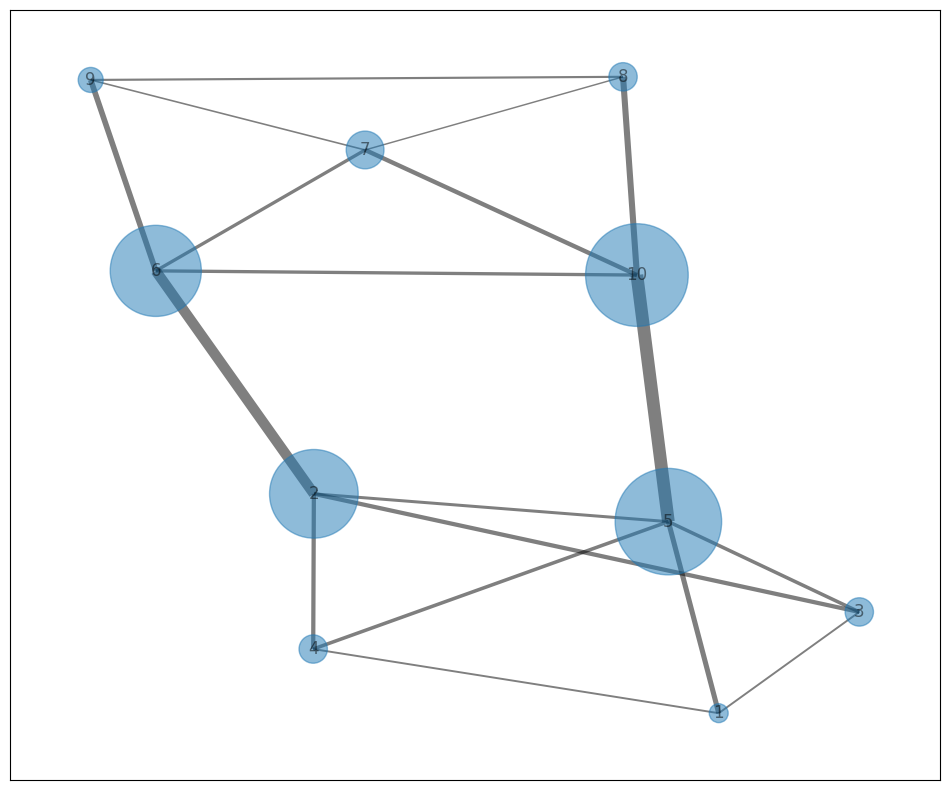

In [22]:
plot_centrality(simple_graph, node_betweenness, edge_betweenness, size=20000, width=30)

Notice the following aspects of the node and edge betweenness for this graph. The nodes with the highest betweenness are the ones with end points for edges between the communities. Correspondingly, the edges between the communities have the highest betweenness.  

> **Exercise 06-5:** Starting with the karate club graph create and execute code in the cell below do the following:   
> 1. Compute the edge betweenness.
> 2. Compute and print the node betweenness centrality.
> 3. Plot the graph showing edge betweenness and betweenness centrality.

{0: 0.43763528138528146, 1: 0.053936688311688304, 2: 0.14365680615680618, 3: 0.011909271284271283, 4: 0.0006313131313131313, 5: 0.02998737373737374, 6: 0.029987373737373736, 7: 0.0, 8: 0.05592682780182781, 9: 0.0008477633477633478, 10: 0.0006313131313131313, 11: 0.0, 12: 0.0, 13: 0.04586339586339586, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.03247504810004811, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.017613636363636363, 24: 0.0022095959595959595, 25: 0.0038404882154882154, 26: 0.0, 27: 0.02233345358345358, 28: 0.0017947330447330447, 29: 0.0029220779220779218, 30: 0.014411976911976909, 31: 0.13827561327561325, 32: 0.145247113997114, 33: 0.30407497594997596}


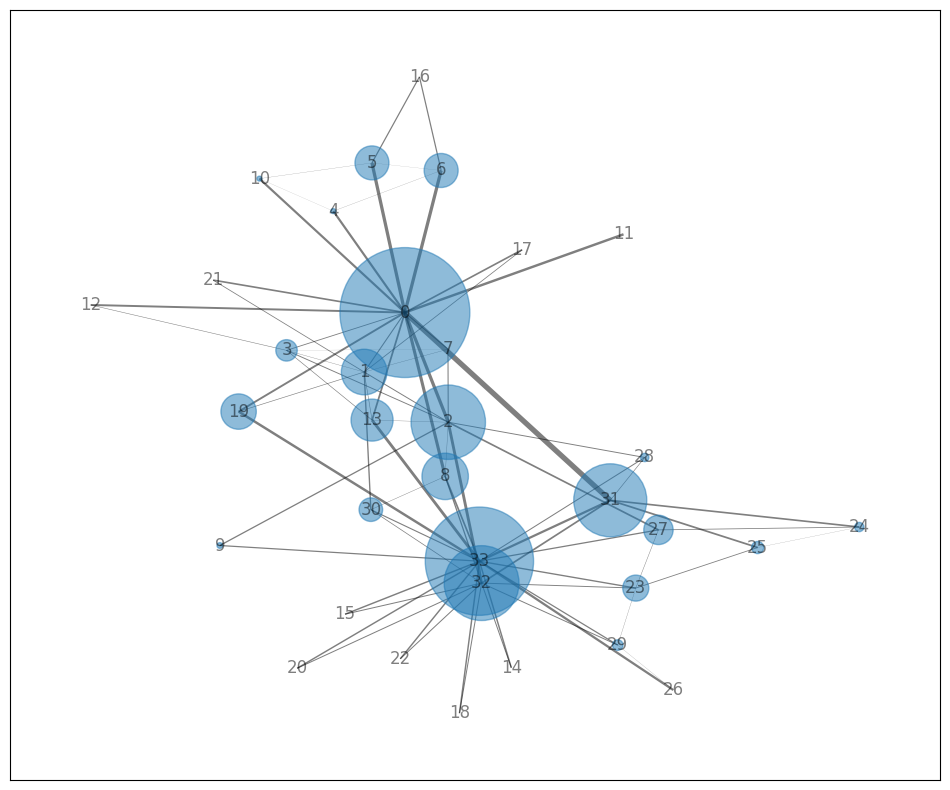

In [23]:
# 1. Compute the edge betweenness
edge_betweenness_karate = nx.edge_betweenness_centrality(K_club)

# 2. Compute and print the node betweenness centrality
node_betweenness_karate = nx.betweenness_centrality(K_club)
print(node_betweenness_karate)

# 3. Plot the graph showing edge betweenness and node betweenness centrality
plot_centrality(K_club, node_betweenness_karate, edge_betweenness_karate, size=20000, width=30)


> Examine this plot and answer the following questions:
> 1. Compare the node betweenness centrality to the nodes in the $k=4$ k-core. Do nodes with high betweenness centrality appear to be largely the same ones in the k-core?   
> 2. Certain edges have relatively high betweenness. Can you see a correspondence between these edges and a possible division of the graph into communities?  
> **End of exercise.**

> **Answers:**

> 1. The nodes with high betweenness centrality, such as nodes 0, 32, and 33, largely overlap with the nodes identified in the k=4 k-core from Exercise 06-2. These nodes are critical connectors within the network, serving as bridges between different parts of the graph. Their high betweenness centrality values indicate their importance in maintaining the flow of information across the network, consistent with their presence in the densest part of the network (the k=4 k-core)

> 2. The edges with high betweenness, such as those connected to nodes 0, 32, and 33, often lie along the boundaries between different communities within the graph. These edges are vital for connecting the distinct subgroups or clusters, and their high betweenness indicates that they are on many of the shortest paths between other nodes. This pattern suggests that the network can potentially be divided into separate communities along these high-betweenness edges, as they represent critical links that, if removed, would result in the most significant disruption of the network's connectivity. Thus, these edges highlight possible divisions in the community structure, aligning with the visual representation of different clusters

### Graph Partitioning with Betweenness

Having explored the betweenness of the two running example graphs, we will now turn our attention to using betweenness to partition these graphs. Since the goal is to partition the graphs by removing edges, we will use edge betweenness.

The Girvan Newman algorithm is a well known method for partitioning graphs into communities using edge betweenness. The algorithm partitions the graph by recursively removing edges with the highest betweenness. Execute the code which uses [networkx.algorithms.community.centrality.girvan_newman](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html?highlight=girvan%20newman#networkx.algorithms.community.centrality.girvan_newman) the function, and examine the results.  

In [24]:
betweenness_decomp = girvan_newman(simple_graph)
betweenness_decomp = tuple(sorted(c) for c in next(betweenness_decomp))
betweenness_decomp

([1, 2, 3, 4, 5], [6, 7, 8, 9, 10])

The Givan Newman algorithm has partitioned the graph into two subsets. These subsets correspond to the communities.    

Execute the code in the cell below to see the graph partitioned by these communities.

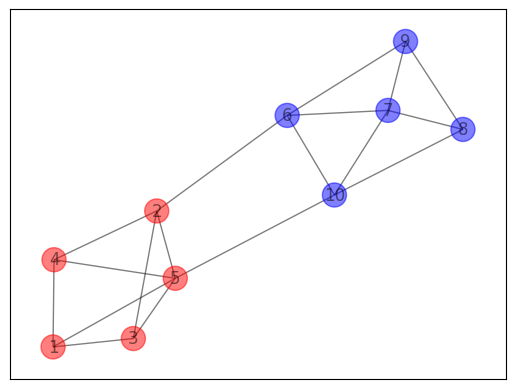

In [25]:
col = ['red','blue']
node_colors = ['None']*len(simple_graph.nodes)
for i,list in enumerate(betweenness_decomp):
    for val in betweenness_decomp[i]:
        node_colors[val-1] = col[i]

nx.draw_networkx(simple_graph, with_labels=True, alpha=0.5, node_color=node_colors)

The figure above shows the communities are labeled as as expected.   

We can take a direct approach to partitioning a graph using edge betweenness. The code in the cell below does just this using a greedy algorithm with the following steps:  
1. The function `remove_edges` prunes the k edges with the highest edge betweenness. In the for loop the betweenness of the current graph is computed. It is important to update the edge betweenness values each time an edge is removed, since the graph changes at each step.     
2. The edge to removed is determined by the `find_max_edge` function. This function searches the edges in the graph and returns the key (endpoint pair of nodes) with the maximum betweenness.  

Execute this code and examine the result.

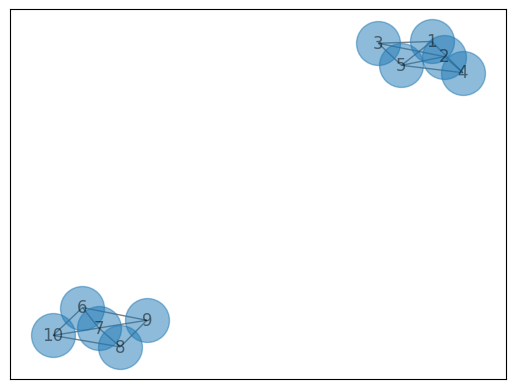

In [26]:
def find_max_edge(temp_betweenness):
    max_key = None
    max_betweenness = 0.0
    for edge in temp_betweenness.keys():
        if temp_betweenness[edge] > max_betweenness:
            max_betweenness = temp_betweenness[edge]
            max_key = edge
    ## Remove edge from dictionary
    temp_betweenness.pop(max_key)
    return max_key

def remove_edges(graph, k=2):
    '''Remove k edges from the graph'''
    temp_graph = graph.copy()
    for _ in range(k):
        ## Compute the betweenness for each graph created as edges are removed
        temp_betweenness = nx.edge_betweenness_centrality(temp_graph)
        max_key = find_max_edge(temp_betweenness)
        temp_graph.remove_edge(max_key[0],max_key[1])
    return temp_graph

partitioned_graph = remove_edges(simple_graph, k=2)

nx.draw_networkx(partitioned_graph, with_labels=True, alpha=0.5, node_size=1000)

The partition of the simple graph into the two communities is exactly as expected.

You will apply the betweenness-based graph partitioning to the karate club graph. But first, it will be useful to see the actual partitioning of the club members that resulted from the club splitting in a dispute. The club split into two communities, one centered around a key figure, Mr Hi, and the other around an officer of the club. To see this partition, execute the code in the cell below.

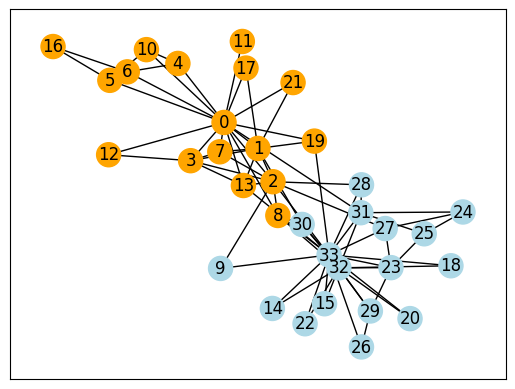

In [27]:
club_color = {
    'Mr. Hi': 'orange',
    'Officer': 'lightblue',
}
node_colors = [club_color[K_club._node[n]['club']] for n in K_club._node]
nx.draw_networkx(K_club, node_color=node_colors, with_labels=True)

Examine this result, keeping in mind that Mr Hi is represented by node 0 and the officer by node 33.

> **Exercise 06-6:** To understand how the karate club graph can be partitioned using edge betweenness create and execute code in the cell below to do so. Use a for loop to remove between 9 and 15 edges from the graph. For each iteration of the for loop do the following:  
> 1. Compute a partitioned graph for each number of edges to remove using the `remove_edges` function.
> 2. Print the number of edges removed as a label of the resulting graph.
> 3. Display the plot of the partitioned graph, using the show method to ensure each plot is displayed individually.

Number of edges removed: 9


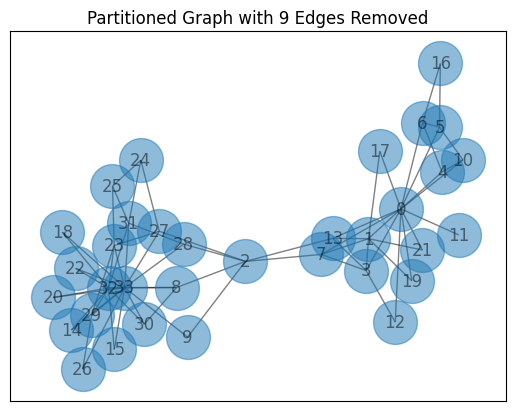

Number of edges removed: 10


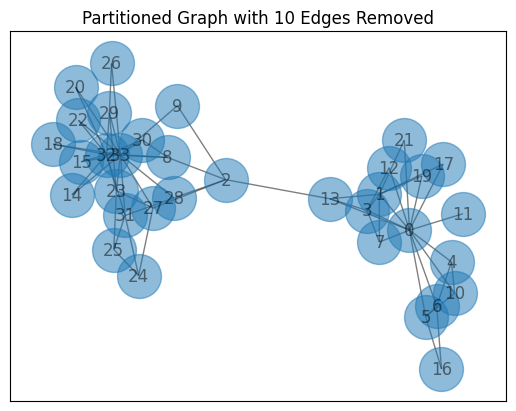

Number of edges removed: 11


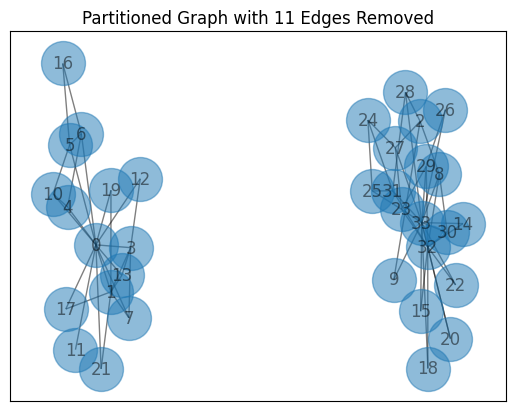

Number of edges removed: 12


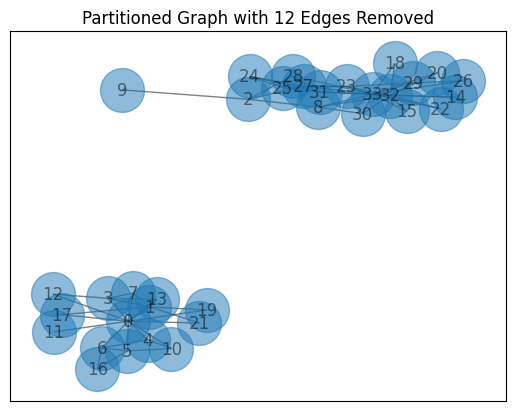

Number of edges removed: 13


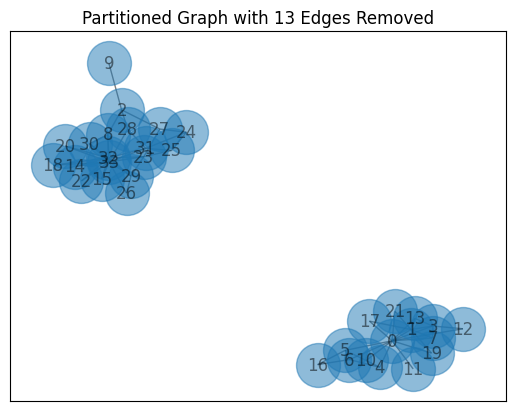

Number of edges removed: 14


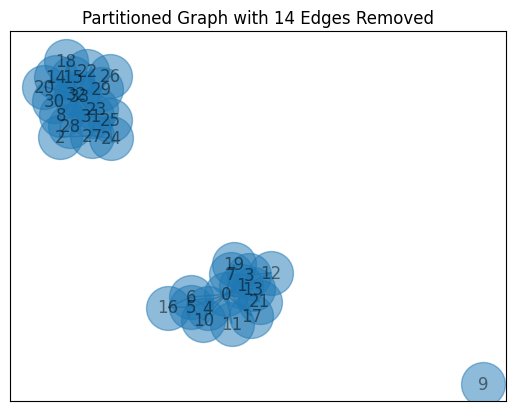

Number of edges removed: 15


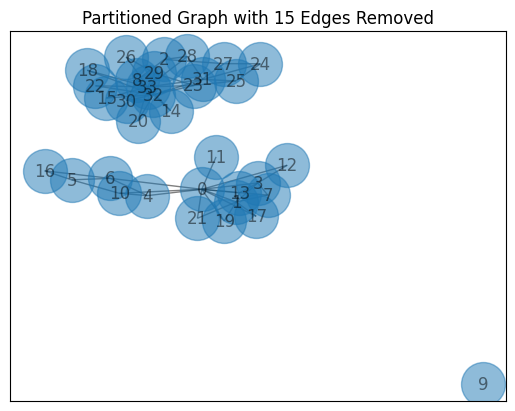

In [28]:
# Define the function to find the edge with the maximum betweenness
def find_max_edge(temp_betweenness):
    max_key = None
    max_betweenness = 0.0
    for edge in temp_betweenness.keys():
        if temp_betweenness[edge] > max_betweenness:
            max_betweenness = temp_betweenness[edge]
            max_key = edge
    temp_betweenness.pop(max_key)
    return max_key

# Define the function to remove k edges from the graph
def remove_edges(graph, k=2):
    temp_graph = graph.copy()
    for _ in range(k):
        temp_betweenness = nx.edge_betweenness_centrality(temp_graph)
        max_key = find_max_edge(temp_betweenness)
        temp_graph.remove_edge(max_key[0], max_key[1])
    return temp_graph

# Loop to remove between 9 and 15 edges and display the resulting graphs
for k in range(9, 16):
    # 1. Compute the partitioned graph
    partitioned_graph = remove_edges(K_club, k=k)

    # 2. Print the number of edges removed
    print(f'Number of edges removed: {k}')

    # 3. Display the plot of the partitioned graph
    nx.draw_networkx(partitioned_graph, with_labels=True, alpha=0.5, node_size=1000)
    plt.title(f'Partitioned Graph with {k} Edges Removed')
    plt.show()


> Examine these results and answer the following questions:  
> 1. How many edges must be removed to create a graph with two components, each representing a community?    
> 2. Are the members of these two communities found with the graph partitioned reasonably aligned with the actual split of the karate club?  
> 3. How many edges must be removed before the graph partition starts to produce isolated singletons?
> **End of exercise.**

> **Answers:**

> 1. To partition the graph into two distinct components representing two communities, we observe that removing 11 edges results in two separate groups, as seen in the corresponding plot. This separation aligns with the actual split of the karate club into two factions

> 2. The partitioned graph with two components after removing 11 edges reflects the real-world division between Mr. Hi's group and the officer's group. The two main components correspond to the actual communities, indicating that the algorithm effectively captured the network's inherent community structure

> 3. Isolated singletons begin to appear after removing 14 edges, as node 9 becomes a separate component. This continues with node 9 remaining isolated even as more edges are removed, confirming that after this point, further partitioning leads to single nodes becoming their own components

## Modularity and Graph Partitioning   

Modularity of a graph measures the concentration of edges to certain nodes compared the number expected for a random graph. Since we expect communities to have a high concentration of edges, modularity can be used as a community detection metric.      

There are many proposals for algorithms one can use to partition a graph. In these exercises will we look at only one, greedy partitioning algorithm. The algorithm is conceptually simple, starting with a random allocation of nodes to two equal partitions of the graph. Nodes chosen at random one at a time are moved from one component to the other. In this process, the community assignment of the chosen node is changed to the other community. If the modularity of the graph improves the new assignment is retained. Otherwise the node retains its current assignment.  

To see this algorithm applied to the simple example graph execute the code in the cell below, which uses the [networkx.algorithms.community.modularity_max.greedy_modularity_communities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html?highlight=greedy%20modularity#networkx.algorithms.community.modularity_max.greedy_modularity_communities) function.

[frozenset({1, 2, 3, 4, 5}), frozenset({6, 7, 8, 9, 10})]


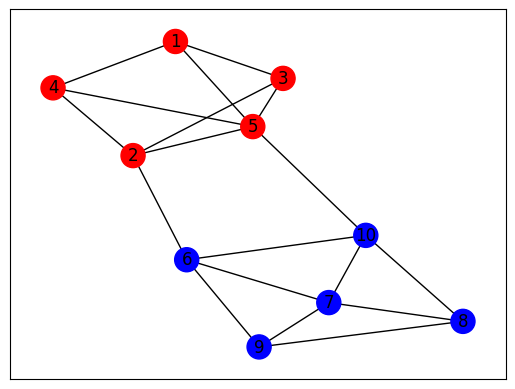

In [29]:
def assign_node_colors(G, communities, col, first_node_number=0):
    ## first unpack the list of frozen sets to a list of lists
    ## so we can actually work with the results
    node_lists = []
    for i in range(len(communities)):
        node_lists.append([x for x in set(communities[i])])

    ## Now, assign colors from the color dictionary
    node_colors = [' ']*len(G.nodes)
    for i in range(len(communities)):
        for j in node_lists[i]:
            node_colors[j-first_node_number] = col[i]
    return node_colors

## Find the modular communities
modular_communities = greedy_modularity_communities(simple_graph)
print(modular_communities)

## Get the color list for the nodes
node_colors = assign_node_colors(simple_graph, modular_communities, col, first_node_number=1)

## Finally draw the graph with the colors showing the communities
nx.draw_networkx(simple_graph, node_color=node_colors)

The greedy modularity algorithm has found the expected two communities.   

> **Exercise 06-7:** Complete the code in the cell below to apply the greedy modularity algorithm to the partition of the karate club graph. Assign the partitioned graph to a variable named `club_modular_communities`. Print the `club_modular_communities`. Execute the code and examine the results.

[frozenset({8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}), frozenset({0, 16, 19, 4, 5, 6, 10, 11})]
['blue', 'gray', 'gray', 'gray', 'blue', 'blue', 'blue', 'gray', 'red', 'gray', 'blue', 'blue', 'gray', 'gray', 'red', 'red', 'blue', 'gray', 'red', 'blue', 'red', 'gray', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']


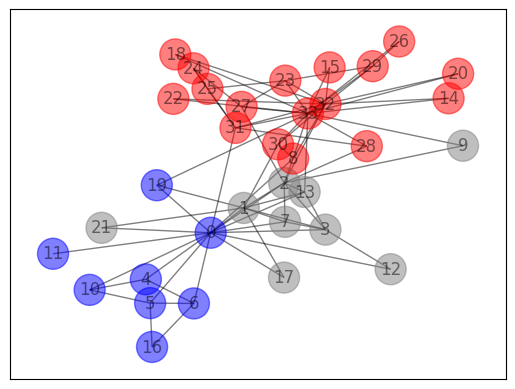

In [30]:
## Color dictionary for displaying the graph
col = {0: 'red', 1: 'gray', 2: 'blue'}

## Find the modular communities
club_modular_communities = greedy_modularity_communities(K_club)
print(club_modular_communities)

## Set the node colors
node_colors = assign_node_colors(K_club, club_modular_communities, col)
print(node_colors)

## Finally, draw the graph with the colors showing the communities
nx.draw_networkx(K_club, with_labels=True, alpha=0.5, node_size=500, node_color=node_colors)
plt.show()


> Examine the graph noticing the partition of the graph. At first this partition seems odd. But, there might be an explanation. Do you see evidence that the third partition might be club members with no particularly stronger connection to either of the factions that split the club? To answer this question, look back at the k-core for $k=4$ and the betweenness centrality plots you created in exercises 06-3 and 06-6.     
> **End of exercise.**     

> **Answer:**

>> In examining the graph and the partitioning results, we observe three distinct groups identified by the greedy modularity algorithm:
- Red Nodes: This group corresponds to a large community, primarily aligning with Mr. Hi's faction. These members have a strong internal connection and are distinct from other groups.
- Gray Nodes: This group appears to be a set of members who are not strongly affiliated with either faction, possibly representing members with weaker connections within the club. This is supported by their relatively lower centrality and absence from the core in the k=4 k-core analysis.
- Blue Nodes: This group mainly represents the officer's faction, with members who stayed loyal to the officer during the split.

>> Evidence and Analisis:
- The k-core analysis highlighted the most central members of the network. Nodes in the gray group had lower centrality measures and were not part of the core group, suggesting they might not have had strong ties to either faction
- The gray group's members generally had lower betweenness centrality, indicating they were not critical connectors in the network. This further supports the idea that they were not central to either faction's core structure.

>> The existence of a third partition, the gray group, could indeed represent members who did not have a strong allegiance to either side during the split. They might have had weaker connections within the network, making them less influential or committed to either group. This partitioning, although initially unexpected, makes sense when considering the network's overall structure and the possible social dynamics at play during the club's division.


#### Copyright 2021, 2022, 2023, Stephen F Elston. All rights reserved.